In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
import Bio.PDB

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

sys.path.insert(0,'../scripts/')
from calc_substitution_matrices import calc_substitution_matrix
from plot_substitution_matrices import plot_substitution_matrix_heatmap,plot_substitution_matrix_counts

## Define functions

In [5]:
def plot_hierarchical_clustering(struc_type,matrix_name,matrix_type):
    """
    Perform hierarchical clustering of average or median abundance score
    substitution matrix and plot results. Clustering is performed for
    both matrix rows and columns. 
    """
    # load substitution matrix
    matrix = pd.read_pickle(
        f"../output/substitution_matrices/dimers/{struc_type}/{matrix_name}/{matrix_type}.pkl"
    )
    
    # find nan entries in matrix (should correspond to synonymous 
    # substitutions) and set average or median score to 1
    nan_matrix = np.isnan(matrix)
    matrix[np.isnan(matrix)] = 1.0
    
    # hierarchical clustering and plot results
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.7)
    m = sns.clustermap(
        matrix, vmin=0, vmax=1, cmap='rocket', mask=nan_matrix, 
        method="average", row_cluster=True, col_cluster=True, cbar_pos=None
    )
    plt.xlabel('Mutation to')
    plt.ylabel('Mutation from')
    plt.yticks(rotation=0)
    plt.tight_layout()

def prepare_data_pca(struc_type):
    """
    Reformat average abundance score substitution matrix
    by joining the 20 mutation from and the 20 mutation to
    scores for a given residue in a single row. 
    """
    # get substitution matrix
    df = pd.read_pickle(f"../output/substitution_matrices/dimers/{struc_type}/all/mean.pkl")

    # set average scores for synonymous substitutions to 1
    df[np.isnan(df)] = 1.0

    # aggregate substitution to and from scores for each amino acid
    agg_scores_list = []
    for aa in df.columns:
        agg_scores_list.append(list(df[aa]) + list(df.loc[aa]))

    # make new matrix
    agg_scores_arr = np.array(agg_scores_list)
    agg_scores_matrix = pd.DataFrame(
        agg_scores_arr, columns=list(df.index + "_to") + list(df.columns + "_from"), index=df.columns
    )

    return agg_scores_matrix

def perform_pca(input_df):
    """
    Do PCA on input data and transform input data
    by projecting it onto the principal components
    """
    # perform PCA and store results in DataFrame
    pca = PCA()
    pca.fit(input_df)
    pca_data = pca.transform(input_df)
    
    # make dataframe with results
    pc_labels = ["PC" + str(i) for i in range(1,len(input_df)+1)]
    pca_df = pd.DataFrame(pca_data, columns = pc_labels, index = input_df.index)
    
    return pca, pca_df

def plot_biplot_pca(pca, pca_df, pc_1, pc_2, struc_type):
    """
    Given the result of the PCA, make biplot with
    principal components specified by pc_1 and pc_2. 
    """
    # get explained variance for PCs
    explained_var_1 = np.around(pca.explained_variance_ratio_[int(pc_1[-1])-1]*100,1)
    explained_var_2 = np.around(pca.explained_variance_ratio_[int(pc_2[-1])-1]*100,1)

    # plot
    sns.reset_orig() 
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(7,5))

    plt.scatter(pca_df[pc_1],pca_df[pc_2],s=25,color="teal",alpha=0.6)

    plt.xlabel(f"{pc_1} ({explained_var_1}% variance explained)")
    plt.ylabel(f"{pc_2} ({explained_var_2}% variance explained)")

    plt.xlim(min(pca_df[pc_1])-0.1,max(pca_df[pc_1])+0.1)
    plt.ylim(min(pca_df[pc_2])-0.1,max(pca_df[pc_2])+0.1)

    # annotate plot with amino acid names
    for i in pca_df.index:
        plt.annotate(i, (pca_df[pc_1].loc[i], pca_df[pc_2].loc[i]))

    plt.title(struc_type[0].upper() + struc_type[1:], fontsize=17)
        
    plt.tight_layout()
    plt.show()    
    
def get_crystal_struct_resi_arr(prot):
    """
    Make array with residue numbers for residues
    present in the protein crystal structure. 
    """
    # define data path and structure file names 
    pdb_file_path = "../data/pdb_files/crystal_structures/processed/"
    struc_dict_pdb = {
        "PTEN":"1d5r_A_noHET.pdb","TPMT":"2h11_A_noHET.pdb","CYP2C9":"1r9o_A_noHET.pdb",
        "NUDT15":"5bon_A_noHET.pdb","ASPA":"2o53_A_noHET.pdb","PRKN":"5c1z_A_noHET.pdb"
    } 
    
    # load structure with biopython
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure("", pdb_file_path+struc_dict_pdb[prot])
    
    # loop over residues and extract residue numbers
    crystal_struct_resi_list = []
    for residue in structure[0].get_residues():
        crystal_struct_resi_list.append(residue.get_id()[1])
        
    crystal_struct_resi_arr = np.array(crystal_struct_resi_list)
    
    return crystal_struct_resi_arr

def analyse_dihedrals(struc_path):
    """
    Calculate phi and psi angles for all residues
    in protein structure and return dataframe with
    those residues for which phi and psi angles
    match those found in left-handed helix structure. 
    """
    # three to one letter codes
    aa_name_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
                    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
                    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
                    'ALA': 'A', 'VAL': 'V' ,'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    
    # load structure
    structure = md.load(struc_path)
    top = structure.topology
    table, bonds = top.to_dataframe()

    # calculate phi angles
    phi_indices, phi_angles = md.compute_phi(structure, periodic=False, opt=True)
    phi_angles = phi_angles[0] * (180/np.pi)
    phi_angles = np.insert(phi_angles,0,np.nan)

    # calculate psi angles
    psi_indices, psi_angles = md.compute_psi(structure, periodic=False, opt=True)
    psi_angles = psi_angles[0] * (180/np.pi)
    psi_angles = np.append(psi_angles,np.nan)

    # make dataframe with results
    residue_numbers = np.unique(table['resSeq'])
    residue_names = [aa_name_dict[(str(i))[:3]] for i in list(top.residues)]   
    df = pd.DataFrame(zip(residue_numbers,residue_names),columns=['resi','resi_name'])
    df['phi_angles'] = phi_angles
    df['psi_angles'] = psi_angles

    # filter dataframe to only include residues with phi and psi angles
    # corresponding to those of residues forming left-handed helix
    gamma_loop_df = df[(df['phi_angles'] > 0) & (df['phi_angles'] < 180) & 
                       (df['psi_angles'] > -90) & (df['psi_angles'] < 90)]
    
    return gamma_loop_df    
    
def make_helix_propensity_matrix(propensity_scale):
    """
    Make amino acid substitution matrix from
    helix propensity scale by calculating differences
    in helix propensity scale ddG values for all
    possible amino acid residue pairs.
    """
    # definer amino acid types
    amino_acid_list = [
        'A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'
    ]
    
    # make dict
    propensity_matrix = {}
    
    # loop over amino acid pairs to calculate difference
    # between helix propensities for residues in each pair
    for aa_from in amino_acid_list:
        
        propensity_matrix[aa_from] = {} 
    
        for aa_to in amino_acid_list:
            
            # use nan for synonymous
            if aa_from == aa_to:
                propensity_matrix[aa_from][aa_to] = np.nan
                
            # calc difference for nonsynonymous
            else:
                propensity_matrix[aa_from][aa_to] = propensity_scale[aa_from] - propensity_scale[aa_to] 

    # make dataframe from dict
    helix_propensity_matrix = pd.DataFrame(propensity_matrix)
    
    return helix_propensity_matrix

def correlate_abundance_helix_propensity(struc_type,matrix_name,matrix_type,propensity_scale):
    """
    Correlate values in average/median abundance score substitution matrix
    with values in helix propensity substitution matrix for a given 
    abundance score substitution matrix type and helix propensity scale.
    """
    # get substitution matrix with average abundance scores
    substitution_matrix = pd.read_pickle(f"../output/substitution_matrices/dimers/{struc_type}/{matrix_name}/{matrix_type}.pkl")
    
    # get helix propensity substitution matrix
    helix_propensity_matrix = make_helix_propensity_matrix(propensity_scale)
    
    # check identical indices and columns
    assert np.all(substitution_matrix.columns == helix_propensity_matrix.columns)
    assert np.all(substitution_matrix.index == helix_propensity_matrix.index)

    # flatten dataframes
    substitution_arr = substitution_matrix.to_numpy().flatten()
    helix_propensity_arr = helix_propensity_matrix.to_numpy().flatten()

    # find shared indices of non-nan values
    intersect_idx = np.intersect1d(np.where(~np.isnan(substitution_arr))[0],np.where(~np.isnan(helix_propensity_arr))[0])

    # calculate correlation coefficients
    r = pearsonr(substitution_arr[intersect_idx],helix_propensity_arr[intersect_idx])[0]
    rs = spearmanr(substitution_arr[intersect_idx],helix_propensity_arr[intersect_idx])[0]
    
    return r, rs

def correlate_abundance_helix_propensity_all(struc_type):
    """
    Run function correlate_abundance_helix_propensity for
    all helix propensity scales. 
    """
    
    # define helix propensity scales (all values are ddGs)
    # all numbers were obtained from doi:10.1016/s0006-3495(98)77529-0

    exp_propensities = {
        'A':0,'R':0.21,'L':0.21,'M':0.24,'K':0.26,'Q':0.39,'E':0.40,'I':0.41,
        'W':0.49,'S':0.50,'Y':0.53,'F':0.54,'V':0.61,'H':0.61,'N':0.65,'T':0.66,
        'C':0.68,'D':0.69,'G':1,'P':np.nan
    }

    akaq_propensities = {
        'A':0,'R':0.22,'L':0.37,'M':0.52,'K':0.29,'Q':0.55,'E':0.62,'I':0.71,
        'W':0.96,'S':0.79,'Y':0.69,'F':1.00,'V':1.04,'H':0.97,'N':0.96,'T':1.22,
        'C':0.91,'D':0.81,'G':1.97,'P':np.nan}

    agadir_propensities = {
        'A':0,'R':0.06,'L':0.19,'M':0.21,'K':0.15,'Q':0.32,'E':0.34,'I':0.35,
        'W':0.47,'S':0.52,'Y':0.47,'F':0.47,'V':0.46,'H':0.62,'N':0.6,'T':0.57,
        'C':0.6,'D':0.59,'G':1.1,'P':np.nan
    }

    williams_propensities = {
        'A':0,'R':0.20,'L':0.07,'M':0.11,'K':0.18,'Q':0.14,'E':-0.18,'I':0.32,
        'W':0.39,'S':0.84,'Y':0.67,'F':0.25,'V':0.43,'H':0.36,'N':0.65,'T':0.65,
        'C':0.75,'D':0.42,'G':0.98,'P':np.nan
    }

    cf_propensities = {
        'A':0,'R':0.44,'L':0.21,'M':-0.03,'K':0.26,'Q':0.31,'E':-0.09,'I':0.34,
        'W':0.34,'S':0.65,'Y':0.73,'F':0.29,'V':0.36,'H':0.42,'N':0.75,'T':0.59,
        'C':0.72,'D':0.41,'G':0.85,'P':np.nan
    }

    luque_propensities = {
        'A':0,'R':0.15,'L':0.15,'M':0.18,'K':0.11,'Q':0.30,'E':0.37,'I':0.48,
        'W':0.35,'S':0.48,'Y':0.46,'F':0.35,'V':0.36,'H':0.62,'N':0.52,'T':0.59,
        'C':0.57,'D':0.47,'G':0.79,'P':np.nan
    }
    
    propensity_scale_list = [
        exp_propensities,akaq_propensities,agadir_propensities,williams_propensities,cf_propensities,luque_propensities
    ]

    # make correlation coefficient lists
    r_list = []
    rs_list = []

    # loop over all helix propensity scales and calculate correlation with abundance score substitution matrix
    for propensity_scale in propensity_scale_list:
        r, rs = correlate_abundance_helix_propensity(struc_type,"all","mean",propensity_scale)
        r_list.append(r)
        rs_list.append(rs)

    r_arr = np.array(r_list)
    rs_arr = np.array(rs_list)
    
    return r_arr, rs_arr

def plot_abundance_helix_propensity_correlation(r_arr,scale_name_list,plot_title):
    
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(4,4))

    plt.bar(scale_name_list,-r_arr,width=0.5,color="lightgrey",edgecolor="black")
    plt.plot([-1,6],[0,0],color="black",linewidth=0.5)

    plt.xlim(-0.5,5.5)
    plt.xticks(rotation=-45)
    plt.ylabel(r"$r$")
    plt.title(f"{plot_title}")

    plt.tight_layout()    
    
def compare_matrices(df1,df2):
    """
    Calculate r and MAE between two substitution matrices,
    given as input as Pandas DataFrames. 
    """
    # flatten matrices
    df1_flat = np.concatenate(df1.to_numpy())
    df2_flat = np.concatenate(df2.to_numpy())
    
    # get indices of non-nan values
    float_positions_df1 = np.where(~np.isnan(df1_flat))[0]
    float_positions_df2 = np.where(~np.isnan(df2_flat))[0]
    all_float_positions = np.intersect1d(float_positions_df1,float_positions_df2)
    
    # remove nan values
    x = df1_flat[all_float_positions]
    y = df2_flat[all_float_positions]
    
    # calculate r and mae
    pearson_corr = pearsonr(x,y)[0]
    mae = np.mean(np.abs(x-y)) 
    
    return pearson_corr, mae

def compare_matrices_envs(matrix_type):
    """
    Calculate r and MAE between average or median abundance score 
    substitution matrices calculated for variants in different
    structural environments.
    matrix_type : mean or median, specifies whether to use subsitution 
    matrices of average or median abundance scores. 
    """
    # define structural environments to analyse
    env_list = ["global","buried","exposed","helix","strand","loop"]

    # define path
    path_prefix = "../output/substitution_matrices/dimers"

    # make dicts 
    env_corr_dict = {}
    env_diff_dict = {}

    for i in env_list[:-1]:
        env_corr_dict[i] = {}
        env_diff_dict[i] = {}

    # loop over environments and calculate r and mae between matrices
    # based on variants sitting in the different environments
    for i,j in itertools.combinations(env_list,2):

        df1 = pd.read_pickle(f"{path_prefix}/{i}/all/{matrix_type}.pkl")
        df2 = pd.read_pickle(f"{path_prefix}/{j}/all/{matrix_type}.pkl")

        corr, diff = compare_matrices(df1,df2)

        env_corr_dict[i][j] = corr
        env_diff_dict[i][j] = diff
    
    # make dataframes from dictionaries
    env_corr_df = pd.DataFrame(env_corr_dict)
    env_diff_df = pd.DataFrame(env_diff_dict)
    
    return env_corr_df, env_diff_df

def compare_matrices_proteins(env_type,matrix_type,leave_out_prot=False):
    """
    Calculate r and MAE between average or median abundance score 
    substitution matrices calculated using data from a single protein
    (leave_out_prot=False) or omitting data from a single protein
    (leave_out_prot=True). 
    """
    # list protein names
    prot_list = ["PTEN","TPMT","CYP2C9","NUDT15","ASPA","PRKN"]

    # define path
    path_prefix = "../output/substitution_matrices/dimers"
    
    # make dicts
    prot_corr_dict = {}
    prot_diff_dict = {}

    for i in prot_list[:-1]:
        prot_corr_dict[i] = {}
        prot_diff_dict[i] = {}

    # loop over pairs of proteins and calculate r and mae between
    # substitution matrices calculated with (or without) data for these proteins
    for prot1,prot2 in itertools.combinations(prot_list,2):

        if leave_out_prot == True:
            df1 = pd.read_pickle(f"{path_prefix}/{env_type}/leave_out_{prot1}/{matrix_type}.pkl")
            df2 = pd.read_pickle(f"{path_prefix}/{env_type}/leave_out_{prot2}/{matrix_type}.pkl")

        else:
            df1 = pd.read_pickle(f"{path_prefix}/{env_type}/{prot1}/{matrix_type}.pkl")
            df2 = pd.read_pickle(f"{path_prefix}/{env_type}/{prot2}/{matrix_type}.pkl")
            
        corr, diff = compare_matrices(df1,df2)

        prot_corr_dict[prot1][prot2] = corr
        prot_diff_dict[prot1][prot2] = diff
        
    # make dataframes from dictionaries
    prot_corr_df = pd.DataFrame(prot_corr_dict)
    prot_diff_df = pd.DataFrame(prot_diff_dict) 
        
    return prot_corr_df, prot_diff_df

def plot_compare_matrices(df, vmin, vmax, cmap, cbar_label):
    """
    """
    plt.figure(figsize=(5.5,5.5))
    sns.set(font_scale=1.2)
    sns.heatmap(
        df,vmin=vmin,vmax=vmax,cmap=cmap,annot=True,linewidth=.5,
        square=True,cbar_kws={'label':cbar_label,'shrink':0.70}
    )
    plt.tight_layout()

## Run calculations and plot results

### Hierarchical clustering of average substitution profiles in buried and exposed environments

/tmp/ipykernel_1494027/976390532.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()
  cmap.set_bad("silver")


<Figure size 576x576 with 0 Axes>

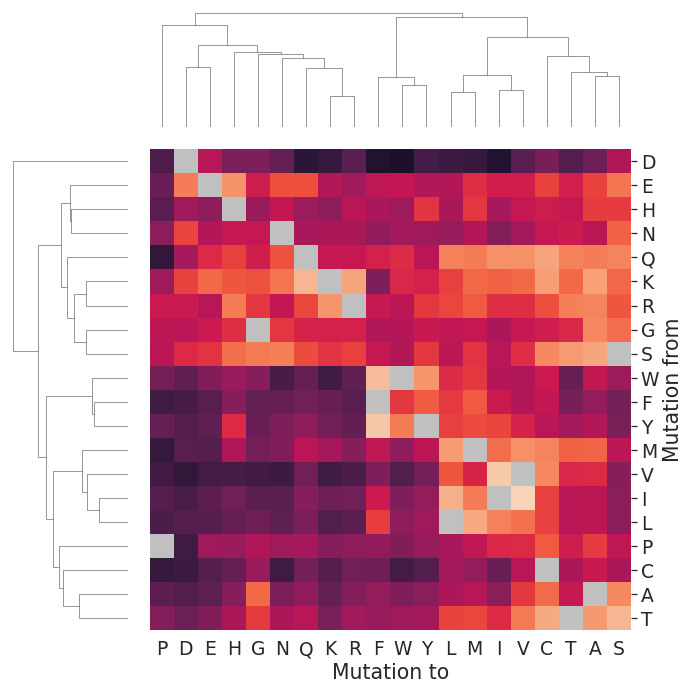

<Figure size 576x576 with 0 Axes>

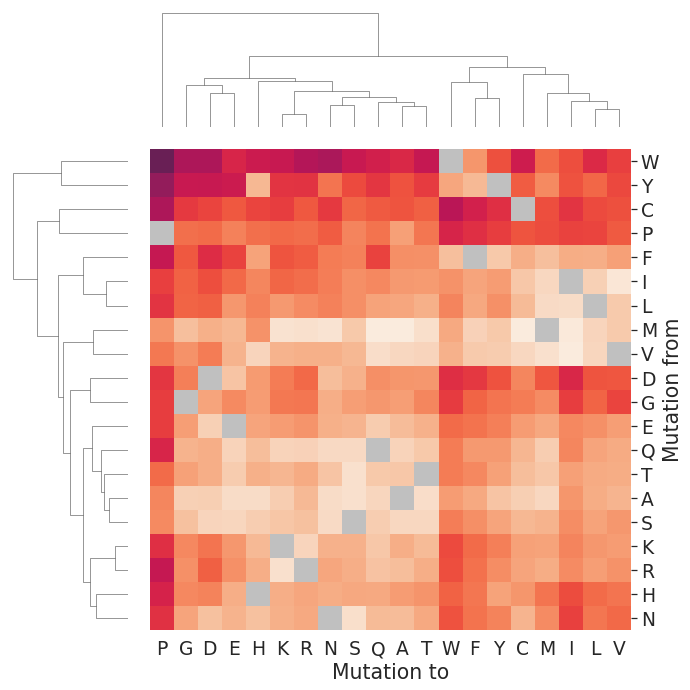

In [6]:
# perform hierarchical clustering of average abundance score substitution matrices
# calculated for residues sitting in buried and exposed environments

# set plotting parameters
cmap = mpl.cm.get_cmap('rocket')
cmap.set_bad("silver")

# loop over structural environemnts
for struc_type in ["buried","exposed"]:
    
    # define types of matrices to analyse
    matrix_name = "all"
    matrix_type = "mean"
    
    # perform and plot clustering
    plot_hierarchical_clustering(struc_type,matrix_name,matrix_type)

### Principal component analysis of average substitution profiles in buried and exposed environments

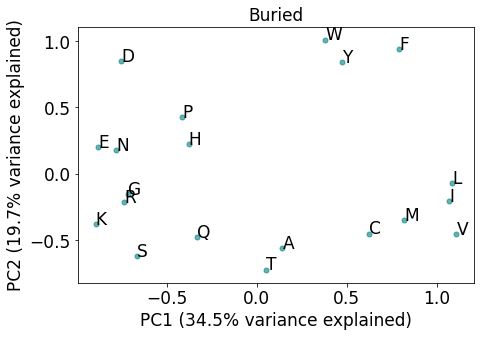

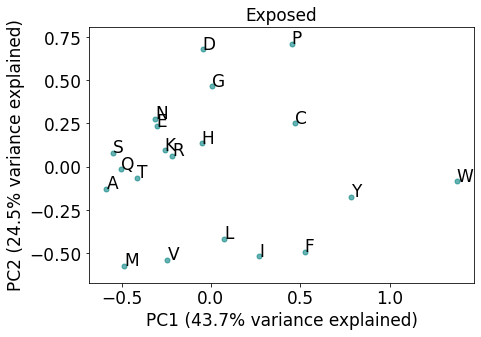

In [39]:
# perform PCA of amino acid substitution profiles in average abundance score matrices
# calculated seperately for residues in buried and exposed environments

for struc_type in ["buried","exposed"]:
    
    # perform analysis
    input_df = prepare_data_pca(struc_type)
    pca, pca_df = perform_pca(input_df)

    # plot results (only first and second PCs)
    plot_biplot_pca(pca, pca_df, "PC1", "PC2", struc_type)

### Analysis of substitution profiles of loop residues with left-handed helix backbone dihedrals 

In [8]:
# define proteins
proteins = ['PTEN','TPMT','NUDT15','CYP2C9','ASPA','PRKN']

# define path to structure files
AF_file_path = "../data/pdb_files/crystal+alphafold_translated_structures/processed/"

# define structure file name dict
struc_dict_AF = {
    "PTEN":"P60484.pdb","TPMT":"P51580.pdb","CYP2C9":"P11712.pdb",
    "NUDT15":"Q9NV35_A.pdb","ASPA":"P45381_A.pdb","PRKN":"O60260.pdb"
}  

In [9]:
# loop over protein structures and find residues with backbone dihedral angles
# similar to those of residues found in left-handed helix structure

left_handed_df_list = []

# loop over proteins
for prot in proteins:

    # identify residues present in crystal structure
    crystal_struct_resi_arr = get_crystal_struct_resi_arr(prot)
    
    # find left-handed helix residues
    left_handed_df = analyse_dihedrals(AF_file_path+struc_dict_AF[prot])
    
    # keep only data for residues originally present in crystal structures
    left_handed_df = left_handed_df[np.isin(left_handed_df.resi.values,crystal_struct_resi_arr)]
    
    # add protein name to dataframe and add dataframe to list
    left_handed_df["prot"] = prot
    left_handed_df_list.append(left_handed_df)

# concatenate dataframes
left_handed_df_all = pd.concat(left_handed_df_list).reset_index().drop(columns="index")

# read structure feature dataframe and merge with left_handed_df_all
struc_df = pd.read_csv("../output/structure_features/structure_features_AF.csv")
struc_df = struc_df.rename(columns={"residue_number":"resi"})

# merge
left_handed_df_all = left_handed_df_all.merge(struc_df,how="left",on=["prot","resi"])

# filter left_handed_df_all to only include residues in assigned to be in loop by dssp
left_handed_in_loop_df = left_handed_df_all[np.isin(left_handed_df_all.secondary_structure.values,["T","S","-"])]

# merge with vampseq data
vampseq_df = pd.read_csv("../data/vampseq_data/processed/vampseq_soluble_df.csv")
vampseq_left_handed_in_loop_df = left_handed_in_loop_df.merge(vampseq_df,how="left",on=["prot","resi"])
vampseq_left_handed_in_loop_df = vampseq_left_handed_in_loop_df.dropna(subset=["abundance_score"])

In [10]:
# calculate and plot average abundance score substitution matrix for residues 
# with backbone dihedral angles similar to those of residues found in left-handed helix structure

# calculate substitution matrix (saved in directory with other substitution matrices)
calc_substitution_matrix(vampseq_left_handed_in_loop_df,"dimers/left_handed_helix_loop/all/")

# load global matrix with averages across all proteins    
global_mean_matrix = pd.read_pickle("../output/substitution_matrices/dimers/global/all/mean.pkl")    

# calculate mean score per row to define aa order in all other plots
mut_from_mean = np.nanmean(global_mean_matrix,axis=1)
global_aa_sort = np.flip(global_mean_matrix.index[np.argsort(mut_from_mean)])       

# load left-handed helix conformation loop residue substitution matrix and variant counts
mean_matrix = pd.read_pickle("../output/substitution_matrices/dimers/left_handed_helix_loop/all/mean.pkl")  
count_matrix = pd.read_pickle("../output/substitution_matrices/dimers/left_handed_helix_loop/all/count.pkl")  

# sort residues according to global_aa_sort scale before plotting 
matrix_sorted = mean_matrix[np.flip(global_aa_sort)].loc[global_aa_sort]

# plot (saved in directory with other substitution matrix plots)
plot_substitution_matrix_heatmap(
    matrix_sorted, vmin=0, vmax=1, figname="dimers/left_handed_helix_loop/all/mean", cmap='rocket'
)

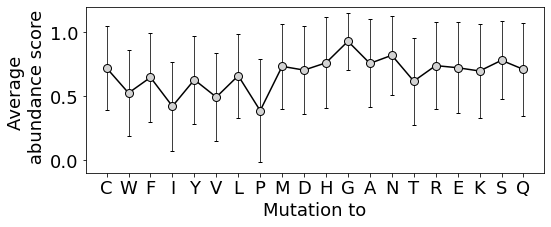

In [12]:
# calculate and plot average abundance scores for "substitution to" the 20 different amino acid types
# specifially for residues with backbone dihedral angles similar to those 
# of residues found in left-handed helix structure

# define residues
amino_acid_list = np.flip(global_aa_sort)

# make arrays with relevant data
aa_ref_arr = vampseq_left_handed_in_loop_df.aa_ref.values
aa_var_arr = vampseq_left_handed_in_loop_df.aa_var.values
abundance_score_arr = vampseq_left_handed_in_loop_df.abundance_score.values

abundance_var_mean_list = []
abundance_var_sd_list = []

# loop over residue types in amino_acid_list
for i in range(len(amino_acid_list)):
    
    # get all abundance scores for which variant residue is aa_var
    aa_var = amino_acid_list[i]    
    score_arr = abundance_score_arr[aa_var_arr == aa_var] 
    
    # calculate mean and sd over all abundance scores for which variant residue is aa_var
    abundance_mean = np.mean(score_arr)
    abundance_sd = np.std(score_arr,ddof=1)
    
    # append to lists
    abundance_var_mean_list.append(abundance_mean)
    abundance_var_sd_list.append(abundance_sd)
    
# plot results    

plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

sns.reset_orig() 

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,3.5))

plt.errorbar(
    x=amino_acid_list,y=abundance_var_mean_list,yerr=abundance_var_sd_list,
    color="black",marker="o",markerfacecolor='lightgrey',ms=8, elinewidth=0.75,capsize=2
)

plt.ylim(-0.1,1.2)
plt.xlabel("Mutation to")
plt.ylabel("Average \n abundance score")
plt.tight_layout()
plt.show()

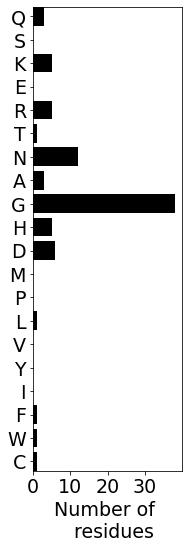

In [17]:
# count and plot number of different amino acid types found
# to have left-handed helix backbone dihedrals across the six proteins

# count number of different residue types
resi_count_df = left_handed_in_loop_df.groupby("resi_name").count()
 
# prepare counts for plotting
resi_count_list = []
for aa in amino_acid_list:
    if aa in resi_count_df.index:
        resi_count_list.append(resi_count_df.loc[aa]["resi"])
    else:
        resi_count_list.append(0)
        
# plot
sns.reset_orig() 
fig = plt.figure(figsize=(3,8))
plt.rcParams.update({'font.size': 19})
plt.barh(amino_acid_list,resi_count_list,color='black')
plt.xlabel('Number of \n  residues')
plt.locator_params(axis='x', nbins=5)
plt.margins(y=0)
plt.tight_layout()

### Correlations between average substitution scores in helix environments and helix propensity scales

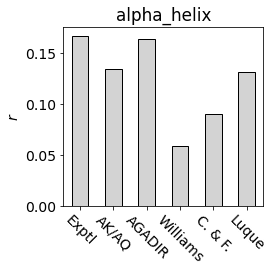

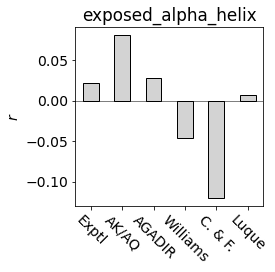

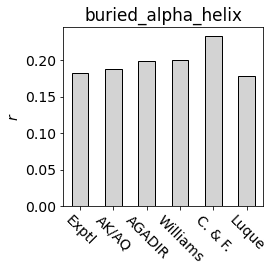

In [18]:
# calculate and plot correlations between helix propensity scale substitution matrices 
# and average abundance score substitution matrices for residues in alpha-helical environments 

scale_name_list = ["Exptl","AK/AQ","AGADIR","Williams","C. & F.","Luque"]

for struc_type in ["alpha_helix","exposed_alpha_helix","buried_alpha_helix"]:
    
    # calculate correlation coefficients
    r_arr, rs_arr = correlate_abundance_helix_propensity_all(struc_type)

    # plot
    plot_abundance_helix_propensity_correlation(r_arr,scale_name_list,struc_type)

### Correlations and differences between abundance score substitution matrices in different environments 

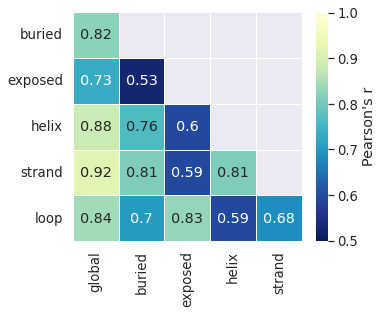

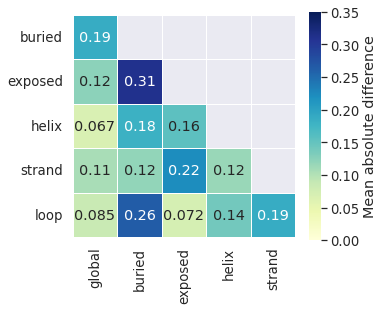

In [19]:
# plot heatmaps showing r and mae between average abundance score
# substitution matrices calculated with variant abundance data for residues
# sitting in different structural environments in the wildtype protein structures

# calculate r and mae between matrices 
env_corr_df, env_diff_df = compare_matrices_envs("mean")

# plot results
plot_compare_matrices(env_corr_df, 0.5, 1, 'YlGnBu_r', 'Pearson\'s r')
plot_compare_matrices(env_diff_df, 0, 0.35, 'YlGnBu', 'Mean absolute difference')

### Correlations and differences between abundance score substitution matrices based on different VAMPseq dataset combinations

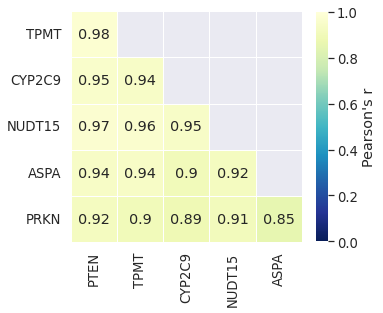

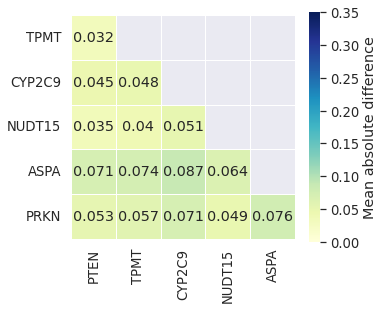

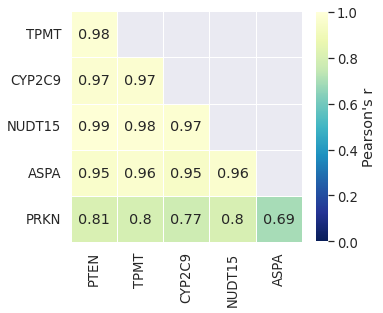

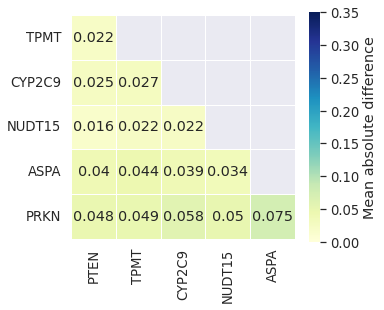

In [20]:
# plot heatmaps showing r and mae between average abundance score substitution matrices 
# calculated by omitting VAMP-seq data for a single protein

# loop over residue environment types
for env_type in ["buried","exposed"]:

    # calculate r and mae between matrices 
    prot_corr_df, prot_diff_df = compare_matrices_proteins(env_type,"mean",leave_out_prot=True)

    # plot results
    plot_compare_matrices(prot_corr_df, 0, 1, 'YlGnBu_r', "Pearson\'s r")
    plot_compare_matrices(prot_diff_df, 0, 0.35, 'YlGnBu', "Mean absolute difference")

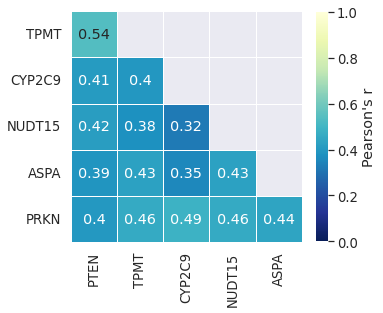

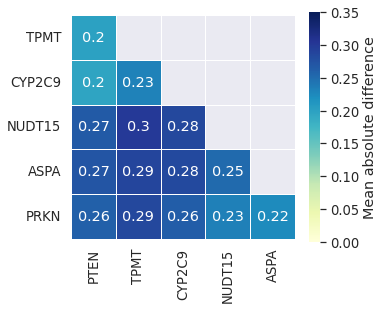

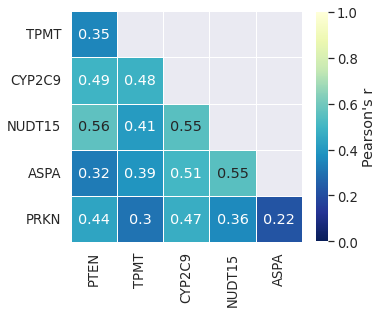

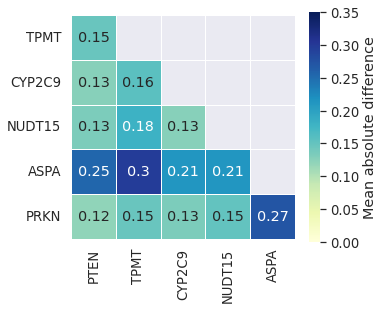

In [21]:
# plot heatmaps showing r and mae between average abundance score substitution matrices
# calculated using VAMP-seq data for single proteins

# loop over residue environment types
for env_type in ["buried","exposed"]:

    # calculate r and mae between matrices 
    prot_corr_df, prot_diff_df = compare_matrices_proteins(env_type,"mean",leave_out_prot=False)

    # plot results
    plot_compare_matrices(prot_corr_df, 0, 1, 'YlGnBu_r', "Pearson\'s r")
    plot_compare_matrices(prot_diff_df, 0, 0.35, 'YlGnBu', "Mean absolute difference")